In [1]:
# from rp_utils import *
import rputils.rputils as rp
import numpy as np
import matplotlib.pyplot as plt
import time

# Lunar Example

Ice -- VP:3.98   VS:1.9   VpVs:2.1   Dens:0.92
Eff Mineral -- VP:6.63   VS:3.62   VpVs:1.83   Dens:2.78


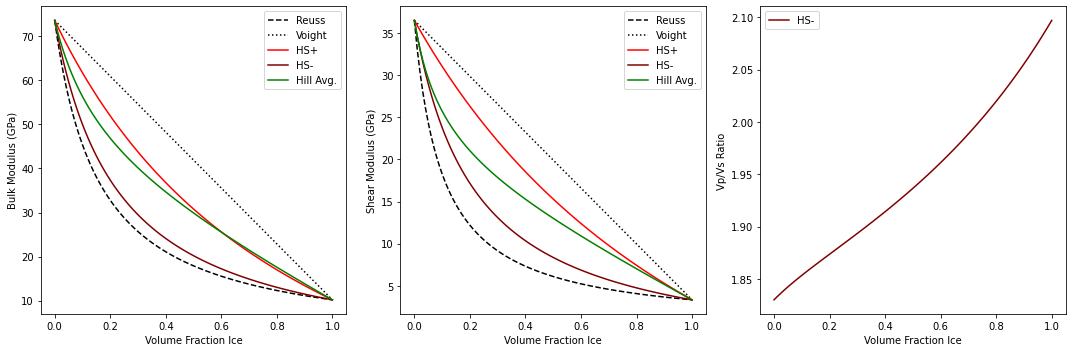

In [12]:
## quick investigation of vp/vs behavior with ice content

## Minerals
k_olivine, u_olivine, f_olivine, d_olivine = 130, 80, 0.05, 3.32  #from RP handbook
k_diopside, u_diopside, f_diopside, d_diopside = 111.2, 63.7, 0.1, 3.31   #from RP handbook
k_plag, u_plag, f_plag, d_plag = 75.6, 25.6, 0.15, 2.63     #from RP handbook
k_anorthite, u_anorthite, f_anorthite, d_anorthite = 66., 33.7, 0.7, 2.7  # from Brown 2016

min_volume_fractions = [f_olivine, f_diopside, f_plag, f_anorthite]
min_bulk_mods = [k_olivine, k_diopside, k_plag, k_anorthite]
min_shear_mods = [u_olivine, u_diopside, u_plag, u_anorthite]
min_densities = [d_olivine, d_diopside, d_plag, d_anorthite]


## Ice
ice_temp = -50
# ice_vp = (-2.3*ice_temp + 3795) / 1000  # from Kohnen 1974
# ice_vs = (-1.2*ice_temp + 1915) / 1000
# ice_dens = 0.96
ice_vp = (3837.9 - 2.812*ice_temp) / 1000  # from Vogt 2008
ice_vs = (1826 - 1.425*ice_temp) / 1000
ice_dens = (917 - 0.1403*ice_temp) / 1000 # from Pounder 1965

k_ice = bulk_mod(ice_vp, ice_vs, ice_dens)
u_ice = shear_mod(ice_vs, ice_dens)



## Misc
pressure = 0.00001
critical_porosity = 0.7
rc = 0.01

effective_mineral_k, effective_mineral_u = hs_bound('upper', min_volume_fractions, 
                                                    min_bulk_mods, min_shear_mods, porosity=0)

poisson_mineral = poisson_mod(effective_mineral_k, effective_mineral_u)
poisson_ice = poisson_mod(k_ice, u_ice)

eff_min_density = sum([f*d for f, d in zip(min_volume_fractions, min_densities)])

eff_min_vp = p_vel_mod(effective_mineral_k, effective_mineral_u, eff_min_density)
eff_min_vs = s_vel_mod(effective_mineral_u, eff_min_density)

ice_vpvs = ice_vp/ice_vs
eff_min_vpvs = eff_min_vp/eff_min_vs

print(f"Ice -- VP:{round(ice_vp,2)}   VS:{round(ice_vs,2)}   VpVs:{round(ice_vpvs,2)}   Dens:{round(ice_dens,2)}")
print(f"Eff Mineral -- VP:{round(eff_min_vp,2)}   VS:{round(eff_min_vs,2)}   VpVs:{round(eff_min_vpvs,2)}   Dens:{round(eff_min_density,2)}")



plot_vol = np.arange(0,1.01,0.01)

reuss_list_k = []
reuss_list_u = []
voight_list_k = []
voight_list_u = []
hs_upper_list_k = []
hs_upper_list_u = []
hs_lower_list_k = []
hs_lower_list_u = []
hill_list_k = []
hill_list_u = []

hill_vpvs = []
hs_lower_vpvs = []

for vol in plot_vol:
    tmp_fracts = [1-vol, vol]
    
    tmp_reuss_k = reuss_average(tmp_fracts, [effective_mineral_k, k_ice])
    reuss_list_k.append(tmp_reuss_k)
    tmp_reuss_u = reuss_average(tmp_fracts, [effective_mineral_u, u_ice])
    reuss_list_u.append(tmp_reuss_u)
    
    voight_list_k.append(voight_average(tmp_fracts, [effective_mineral_k, k_ice]))
    voight_list_u.append(voight_average(tmp_fracts, [effective_mineral_u, u_ice]))
    
    tmp_upper_k, tmp_upper_u = hs_bound('upper', tmp_fracts, [effective_mineral_k, k_ice], [effective_mineral_u, u_ice])
    hs_upper_list_k.append(tmp_upper_k)
    hs_upper_list_u.append(tmp_upper_u)
    tmp_lower_k, tmp_lower_u = hs_bound('lower', tmp_fracts, [effective_mineral_k, k_ice], [effective_mineral_u, u_ice])
    hs_lower_list_k.append(tmp_lower_k)
    hs_lower_list_u.append(tmp_lower_u)
    
    tmp_hill_k = hill_average(tmp_fracts, [effective_mineral_k, k_ice])
    tmp_hill_u = hill_average(tmp_fracts, [effective_mineral_u, u_ice])
    
    hill_list_k.append(tmp_hill_k)
    hill_list_u.append(tmp_hill_u)
    
    tmp_dens = sum([f*d for f, d in zip(tmp_fracts, [eff_min_density, ice_dens])])
    
    tmp_vp_hill = p_vel_mod(tmp_hill_k, tmp_hill_u, tmp_dens)
    tmp_vs_hill = s_vel_mod(tmp_hill_u, tmp_dens)
    hill_vpvs.append(tmp_vp_hill/tmp_vs_hill)
    
    tmp_vp_hslower = p_vel_mod(tmp_lower_k, tmp_lower_u, tmp_dens)
    tmp_vs_hslower = s_vel_mod(tmp_lower_u, tmp_dens)
    hs_lower_vpvs.append(tmp_vp_hslower/tmp_vs_hslower)
    
    
    
    
    
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
ax[0].plot(plot_vol, reuss_list_k, color='black', linestyle='--', label='Reuss')
ax[0].plot(plot_vol, voight_list_k, color='black', linestyle=':', label='Voight')
ax[0].plot(plot_vol, hs_upper_list_k, color='red', label='HS+')
ax[0].plot(plot_vol, hs_lower_list_k, color='maroon', label='HS-')
ax[0].plot(plot_vol, hill_list_k, color='green', label='Hill Avg.')
ax[0].set_xlabel("Volume Fraction Ice")
ax[0].set_ylabel("Bulk Modulus (GPa)")
ax[0].legend()

ax[1].plot(plot_vol, reuss_list_u, color='black', linestyle='--', label='Reuss')
ax[1].plot(plot_vol, voight_list_u, color='black', linestyle=':', label='Voight')
ax[1].plot(plot_vol, hs_upper_list_u, color='red', label='HS+')
ax[1].plot(plot_vol, hs_lower_list_u, color='maroon', label='HS-')
ax[1].plot(plot_vol, hill_list_u, color='green', label='Hill Avg.')
ax[1].set_xlabel("Volume Fraction Ice")
ax[1].set_ylabel("Shear Modulus (GPa)")
ax[1].legend()

# ax[2].plot(plot_vol, hill_vpvs, color='green', label="Hill")
ax[2].plot(plot_vol, hs_lower_vpvs, color='maroon', label="HS-")
ax[2].set_xlabel("Volume Fraction Ice")
ax[2].set_ylabel("Vp/Vs Ratio")
ax[2].legend()

plt.tight_layout()
plt.show()

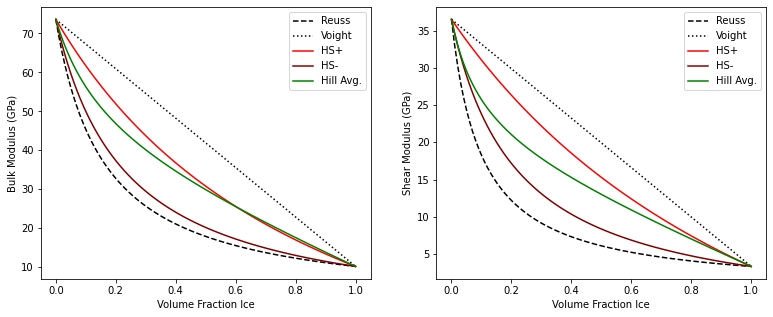

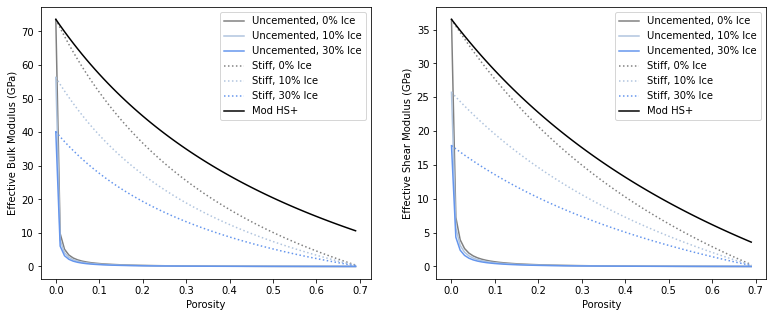

In [3]:
##############################
########   Inputs   ##########


## Minerals
k_olivine, u_olivine, f_olivine, d_olivine = 130, 80, 0.05, 3.32  #from RP handbook
k_diopside, u_diopside, f_diopside, d_diopside = 111.2, 63.7, 0.1, 3.31   #from RP handbook
k_plag, u_plag, f_plag, d_plag = 75.6, 25.6, 0.15, 2.63     #from RP handbook
k_anorthite, u_anorthite, f_anorthite, d_anorthite = 66., 33.7, 0.7, 2.7  # from Brown 2016

min_volume_fractions = [f_olivine, f_diopside, f_plag, f_anorthite]
min_bulk_mods = [k_olivine, k_diopside, k_plag, k_anorthite]
min_shear_mods = [u_olivine, u_diopside, u_plag, u_anorthite]
min_densities = [d_olivine, d_diopside, d_plag, d_anorthite]


## Ice
ice_temp = -50
# ice_vp = (-2.3*ice_temp + 3795) / 1000  # from Kohnen 1974
# ice_vs = (-1.2*ice_temp + 1915) / 1000
# ice_dens = 0.96
ice_vp = (3837.9 - 2.812*ice_temp) / 1000  # from Vogt 2008
ice_vs = (1826 - 1.425*ice_temp) / 1000
ice_dens = (917 - 0.1403*ice_temp) / 1000 # from Pounder 1965

k_ice = bulk_mod(ice_vp, ice_vs, ice_dens)
u_ice = shear_mod(ice_vs, ice_dens)



## Misc
pressure = 0.00001
critical_porosity = 0.7
rc = 0.01


##############################
##############################



effective_mineral_k, effective_mineral_u = hs_bound('upper', min_volume_fractions, 
                                                    min_bulk_mods, min_shear_mods, porosity=0)

poisson_mineral = poisson_mod(effective_mineral_k, effective_mineral_u)
poisson_ice = poisson_mod(k_ice, u_ice)

eff_min_density = sum([f*d for f, d in zip(min_volume_fractions, min_densities)])


##-------------------------------
##-------------------------------
## Mixed mineral to ice moduli

plot_vol = np.arange(0,1.01,0.01)

reuss_list_k = []
reuss_list_u = []
voight_list_k = []
voight_list_u = []
hs_upper_list_k = []
hs_upper_list_u = []
hs_lower_list_k = []
hs_lower_list_u = []
hill_list_k = []
hill_list_u = []

for vol in plot_vol:
    
    tmp_fracts = [1-vol, vol]
    
    tmp_reuss_k = reuss_average(tmp_fracts, [effective_mineral_k, k_ice])
    reuss_list_k.append(tmp_reuss_k)
    tmp_reuss_u = reuss_average(tmp_fracts, [effective_mineral_u, u_ice])
    reuss_list_u.append(tmp_reuss_u)
    
    voight_list_k.append(voight_average(tmp_fracts, [effective_mineral_k, k_ice]))
    voight_list_u.append(voight_average(tmp_fracts, [effective_mineral_u, u_ice]))
    
    tmp_upper_k, tmp_upper_u = hs_bound('upper', tmp_fracts, [effective_mineral_k, k_ice], [effective_mineral_u, u_ice])
    hs_upper_list_k.append(tmp_upper_k)
    hs_upper_list_u.append(tmp_upper_u)
    tmp_lower_k, tmp_lower_u = hs_bound('lower', tmp_fracts, [effective_mineral_k, k_ice], [effective_mineral_u, u_ice])
    hs_lower_list_k.append(tmp_lower_k)
    hs_lower_list_u.append(tmp_lower_u)
    
    hill_list_k.append(hill_average(tmp_fracts, [effective_mineral_k, k_ice]))
    hill_list_u.append(hill_average(tmp_fracts, [effective_mineral_u, u_ice]))
    
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (13,5))
ax[0].plot(plot_vol, reuss_list_k, color='black', linestyle='--', label='Reuss')
ax[0].plot(plot_vol, voight_list_k, color='black', linestyle=':', label='Voight')
ax[0].plot(plot_vol, hs_upper_list_k, color='red', label='HS+')
ax[0].plot(plot_vol, hs_lower_list_k, color='maroon', label='HS-')
ax[0].plot(plot_vol, hill_list_k, color='green', label='Hill Avg.')
ax[0].set_xlabel("Volume Fraction Ice")
ax[0].set_ylabel("Bulk Modulus (GPa)")
ax[0].legend()

ax[1].plot(plot_vol, reuss_list_u, color='black', linestyle='--', label='Reuss')
ax[1].plot(plot_vol, voight_list_u, color='black', linestyle=':', label='Voight')
ax[1].plot(plot_vol, hs_upper_list_u, color='red', label='HS+')
ax[1].plot(plot_vol, hs_lower_list_u, color='maroon', label='HS-')
ax[1].plot(plot_vol, hill_list_u, color='green', label='Hill Avg.')
ax[1].set_xlabel("Volume Fraction Ice")
ax[1].set_ylabel("Shear Modulus (GPa)")
ax[1].legend()
    
plt.show()



##-------------------------------
##-------------------------------
## Models


por_range = np.arange(0,critical_porosity, 0.01)

keff_list = []
ueff_list = []
keff_mix_list_1 = []
ueff_mix_list_1 = []
keff_mix_list_2 = []
ueff_mix_list_2 = []

keff_list_stiff = []
ueff_list_stiff = []
keff_mix_list_1_stiff = []
ueff_mix_list_1_stiff = []
keff_mix_list_2_stiff = []
ueff_mix_list_2_stiff = []

mod_hs_up_k_list = []
mod_hs_up_u_list = []

ice_percent_1 = 0.1

k_icy_mix1 = hill_average([ice_percent_1, 1-ice_percent_1], [k_ice, effective_mineral_k])
u_icy_mix1 = hill_average([ice_percent_1, 1-ice_percent_1], [u_ice, effective_mineral_u])
# k_icy_mix1, u_icy_mix1 = hs_bound('lower', [1-ice_percent_1, ice_percent_1], [effective_mineral_k, k_ice], 
#                                 [effective_mineral_u, u_ice], porosity=0)
poisson_icy_mix1 = poisson_mod(k_icy_mix1, u_icy_mix1)

ice_percent_2 = 0.3
k_icy_mix2 = hill_average([ice_percent_2, 1-ice_percent_2], [k_ice, effective_mineral_k])
u_icy_mix2 = hill_average([ice_percent_2, 1-ice_percent_2], [u_ice, effective_mineral_u])
# k_icy_mix2, u_icy_mix2 = hs_bound('upper', [1-ice_percent_2, ice_percent_2], [effective_mineral_k, k_ice], 
#                                 [effective_mineral_u, u_ice], porosity=0)
poisson_icy_mix2 = poisson_mod(k_icy_mix2, u_icy_mix2)

for por in por_range:
#     C=6
    C = lower_murphy(por)
    
    mod_hs_upper_k, mod_hs_upper_u = modified_hs_upper(effective_mineral_k, k_ice, effective_mineral_u, u_ice, por, critical_porosity)
    mod_hs_up_k_list.append(mod_hs_upper_k)
    mod_hs_up_u_list.append(mod_hs_upper_u)
    
#     khm, uhm = hertz_mindlin(effective_mineral_k, effective_mineral_u, critical_porosity, C, pressure, f=1)
    khm, uhm = hertz_mindlin_angular(effective_mineral_k, effective_mineral_u, por, C,
                                     pressure, Rc_ratio = rc, cohesionless_percent=0.5)
    keff, ueff = uncemented_model(por, critical_porosity, khm, uhm, effective_mineral_k, effective_mineral_u)
    keff_stiff, ueff_stiff = stiff_model(por, critical_porosity, khm, uhm, effective_mineral_k, effective_mineral_u)
    
    keff_list.append(keff)
    ueff_list.append(ueff)
    keff_list_stiff.append(keff_stiff)
    ueff_list_stiff.append(ueff_stiff)
    
#     khm, uhm = hertz_mindlin(k_icy_mix1, u_icy_mix1, critical_porosity, C, pressure, f=1)
    khm, uhm = hertz_mindlin_angular(k_icy_mix1, u_icy_mix1, por, C,
                                     pressure, Rc_ratio = rc, cohesionless_percent=0.5)
    keff, ueff = uncemented_model(por, critical_porosity, khm, uhm, k_icy_mix1, u_icy_mix1)
    keff_stiff, ueff_stiff = stiff_model(por, critical_porosity, khm, uhm, k_icy_mix1, u_icy_mix1)
    
    keff_mix_list_1.append(keff)
    ueff_mix_list_1.append(ueff)
    keff_mix_list_1_stiff.append(keff_stiff)
    ueff_mix_list_1_stiff.append(ueff_stiff)
    
#     khm, uhm = hertz_mindlin(k_icy_mix2, u_icy_mix2, critical_porosity, C, pressure, f=1)
    khm, uhm = hertz_mindlin_angular(k_icy_mix2, u_icy_mix2, por, C,
                                     pressure, Rc_ratio = rc, cohesionless_percent=0.5)
    keff, ueff = uncemented_model(por, critical_porosity, khm, uhm, k_icy_mix2, u_icy_mix2)
    keff_stiff, ueff_stiff = stiff_model(por, critical_porosity, khm, uhm, k_icy_mix2, u_icy_mix2)
    
    keff_mix_list_2.append(keff)
    ueff_mix_list_2.append(ueff)
    keff_mix_list_2_stiff.append(keff_stiff)
    ueff_mix_list_2_stiff.append(ueff_stiff)
    
    
    
    
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (13,5))
ax[0].plot(por_range, keff_list, color='gray', label='Uncemented, 0% Ice')
ax[0].plot(por_range, keff_mix_list_1, color='lightsteelblue', label='Uncemented, 10% Ice')
ax[0].plot(por_range, keff_mix_list_2, color='cornflowerblue', label='Uncemented, 30% Ice')
ax[0].plot(por_range, keff_list_stiff, color='gray', label='Stiff, 0% Ice', linestyle=":")
ax[0].plot(por_range, keff_mix_list_1_stiff, color='lightsteelblue', label='Stiff, 10% Ice', linestyle=":")
ax[0].plot(por_range, keff_mix_list_2_stiff, color='cornflowerblue', label='Stiff, 30% Ice', linestyle=":")
ax[0].plot(por_range, mod_hs_up_k_list, color='black', label='Mod HS+')
ax[0].set_xlabel("Porosity")
ax[0].set_ylabel("Effective Bulk Modulus (GPa)")
ax[0].legend()

ax[1].plot(por_range, ueff_list, color='gray', label='Uncemented, 0% Ice')
ax[1].plot(por_range, ueff_mix_list_1, color='lightsteelblue', label='Uncemented, 10% Ice')
ax[1].plot(por_range, ueff_mix_list_2, color='cornflowerblue', label='Uncemented, 30% Ice')
ax[1].plot(por_range, ueff_list_stiff, color='gray', label='Stiff, 0% Ice', linestyle=":")
ax[1].plot(por_range, ueff_mix_list_1_stiff, color='lightsteelblue', label='Stiff, 10% Ice', linestyle=":")
ax[1].plot(por_range, ueff_mix_list_2_stiff, color='cornflowerblue', label='Stiff, 30% Ice', linestyle=":")
ax[1].plot(por_range, mod_hs_up_u_list, color='black', label='Mod HS+')
ax[1].set_xlabel("Porosity")
ax[1].set_ylabel("Effective Shear Modulus (GPa)")
ax[1].legend()

plt.show()

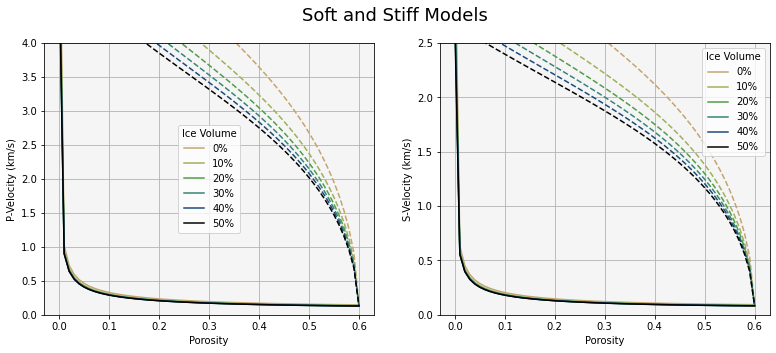

Running self-consistent iteration 3/51

TypeError: 'Float' object is not subscriptable

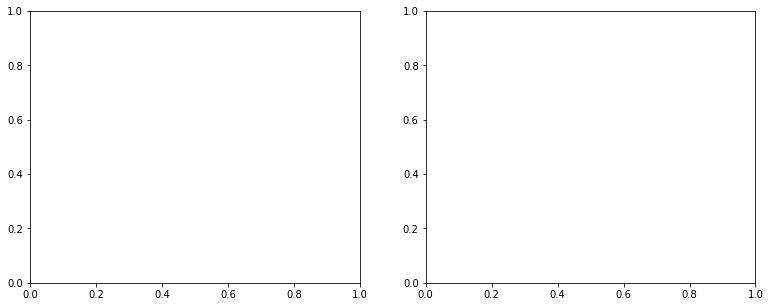

In [2]:
##############################
########   Inputs   ##########


## Mineral Parameters and Mixing
k_olivine, u_olivine, f_olivine, d_olivine = 130, 80, 0.05, 3.32  #from RP handbook
k_diopside, u_diopside, f_diopside, d_diopside = 111.2, 63.7, 0.1, 3.31   #from RP handbook
k_plag, u_plag, f_plag, d_plag = 75.6, 25.6, 0.15, 2.63     #from RP handbook
k_anorthite, u_anorthite, f_anorthite, d_anorthite = 66., 33.7, 0.7, 2.7  # from Brown 2016

min_volume_fractions = [f_olivine, f_diopside, f_plag, f_anorthite]
min_bulk_mods = [k_olivine, k_diopside, k_plag, k_anorthite]
min_shear_mods = [u_olivine, u_diopside, u_plag, u_anorthite]
min_densities = [d_olivine, d_diopside, d_plag, d_anorthite]

effective_mineral_k = hill_average(min_volume_fractions, min_bulk_mods)
effective_mineral_u = hill_average(min_volume_fractions, min_shear_mods)
eff_min_density = sum([f*d for f, d in zip(min_volume_fractions, min_densities)])


## Ice Parameters
ice_temp = -100
# ice_vp = (-2.3*ice_temp + 3795) / 1000  # from Kohnen 1974
# ice_vs = (-1.2*ice_temp + 1915) / 1000
# ice_dens = 0.96
ice_vp = (3837.9 - 2.812*ice_temp) / 1000  # from Vogt 2008
ice_vs = (1826 - 1.425*ice_temp) / 1000
ice_dens = (917 - 0.1403*ice_temp) / 1000 # from Pounder 1965

k_ice = bulk_mod(ice_vp, ice_vs, ice_dens)
u_ice = shear_mod(ice_vs, ice_dens)



## Misc
pressure = 0.0000035
critical_porosity = 0.6
rc = 0.01

uncemented_sand_por = critical_porosity


## Porosity range for evaluation and plotting
porosity_range = np.arange(0, critical_porosity+0.01, 0.01)

## Coordination number from porosity
murphy_C=upper_murphy(porosity_range)



##############################
##############################


## Plot Uncemented and Stiff models for various ice concentrations

ice_percents = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=((13,5)))

for i, ice in enumerate(ice_percents):
    
    k_icy_regolith = hill_average([ice, 1-ice],
                                  [k_ice, effective_mineral_k])
    u_icy_regolith = hill_average([ice, 1-ice],
                                  [u_ice, effective_mineral_u])
    
    dens = sum([f*d for f, d in zip([ice, 1-ice], [ice_dens, eff_min_density])])
    
    vp_soft, vs_soft = [],[]
    vp_stiff, vs_stiff = [],[]
    
    C_hm = 4
    Khm, Uhm = hertz_mindlin_angular(k_icy_regolith, u_icy_regolith, critical_porosity, C_hm,
                                     pressure, Rc_ratio = rc, cohesionless_percent=0.5)
    
    for por, C in zip(porosity_range, murphy_C):
#         Khm, Uhm = hertz_mindlin(k_icy_regolith, u_icy_regolith, critical_porosity, C, pressure, f=1)
#         Khm, Uhm = hertz_mindlin_angular(k_icy_regolith, u_icy_regolith, por, C,
#                                      pressure, Rc_ratio = rc, cohesionless_percent=0.5)

        k_soft, mu_soft = uncemented_model(por, critical_porosity, Khm, Uhm, k_icy_regolith, u_icy_regolith)
        k_stiff, mu_stiff = stiff_model(por, critical_porosity, Khm, Uhm, k_icy_regolith, u_icy_regolith)
        
        vp_soft.append(p_vel_mod(k_soft, mu_soft, dens*(1-por)))
        vs_soft.append(s_vel_mod(mu_soft, dens*(1-por)))
        vp_stiff.append(p_vel_mod(k_stiff, mu_stiff, dens*(1-por)))
        vs_stiff.append(s_vel_mod(mu_stiff, dens*(1-por)))
        
#     n_colors = len(ice_percents)
#     plot_colors = plt.cm.viridis(np.linspace(0,1,n_colors))
    n_colors = len(ice_percents)
    plot_colors = plt.cm.gist_earth_r(np.linspace(0.2,1,n_colors))
    if float(ice*100) == int(ice*100):
        ice_label = '{:.0f}%'.format(ice*100)
    else:
        ice_label = '{:.1f}%'.format(ice*100)
    
    ax[0].plot(porosity_range, vp_soft, color=plot_colors[i], label=ice_label)
    ax[1].plot(porosity_range, vs_soft, color=plot_colors[i], label=ice_label)
    ax[0].plot(porosity_range, vp_stiff,'--', color=plot_colors[i])
    ax[1].plot(porosity_range, vs_stiff,'--', color=plot_colors[i])
    
ax[0].set_xlabel("Porosity")
ax[0].set_ylabel("P-Velocity (km/s)")
ax[1].set_xlabel("Porosity")
ax[1].set_ylabel("S-Velocity (km/s)")
ax[0].set_facecolor('whitesmoke')
ax[1].set_facecolor('whitesmoke')
ax[0].grid('both')
ax[1].grid('both')
ax[0].set_ylim(0,4)
ax[1].set_ylim(0,2.5)
ax[0].legend(title="Ice Volume")
ax[1].legend(title="Ice Volume")
    
fig.suptitle("Soft and Stiff Models", fontsize=18)
plt.show()



##############################
##############################

## Plot Cemented Model for a given transition porosity
start = time.time()

rock_porosity = critical_porosity
cemented_porosity = round(rock_porosity-(rock_porosity*.15), 2)

vp_contact, vs_contact = [],[]
vp_uniform, vs_uniform = [],[]
hs_upper, hs_lower = [], []

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=((13,5)))

C=5

# k_contact, u_contact, por_contact = self_consistent_contact_cement(k_ice, u_ice, effective_mineral_k, 
#                                         effective_mineral_u, cemented_porosity, rock_porosity, C, scheme='contact')
# k_uniform, u_uniform, por_uniform = self_consistent_contact_cement(k_ice, u_ice, effective_mineral_k, 
#                                         effective_mineral_u, cemented_porosity, rock_porosity, C, scheme='uniform')

k_contact, u_contact, por_contact = self_consistent_contact_cement_SYM(k_ice, u_ice, effective_mineral_k, 
                                        effective_mineral_u, cemented_porosity, rock_porosity, C, scheme='contact')
k_uniform, u_uniform, por_uniform = self_consistent_contact_cement_SYM(k_ice, u_ice, effective_mineral_k, 
                                        effective_mineral_u, cemented_porosity, rock_porosity, C, scheme='uniform')

end = time.time()
print("Cemented Model computation time: {} minutes".format(round((end-start)/60)))

ice_vol_contact = rock_porosity - por_contact
ice_vol_uniform = rock_porosity - por_uniform
dens_contact = [sum([f*d for f, d in zip([i, 1-rock_porosity], [ice_dens, eff_min_density])]) for i in ice_vol_contact]
dens_uniform = [sum([f*d for f, d in zip([i, 1-rock_porosity], [ice_dens, eff_min_density])]) for i in ice_vol_uniform]

for k, u, d in zip(k_contact, u_contact, dens_contact):
    vp_contact.append(p_vel_mod(k, u, d))
    vs_contact.append(s_vel_mod(u, d))
    
for k, u, d in zip(k_uniform, u_uniform, dens_uniform):
    vp_uniform.append(p_vel_mod(k, u, d))
    vs_uniform.append(s_vel_mod(u, d))


ax[0].plot(por_contact, vp_contact, color='red', label='Contact')
ax[1].plot(por_contact, vs_contact, color='red', label='Contact')
ax[0].plot(por_uniform, vp_uniform,'--', color='red', label='Uniform')
ax[1].plot(por_uniform, vs_uniform,'--', color='red', label='Uniform')

ax[0].set_xlabel("Porosity")
ax[0].set_ylabel("P-Velocity (km/s)")
ax[1].set_xlabel("Porosity")
ax[1].set_ylabel("S-Velocity (km/s)")
ax[0].set_facecolor('whitesmoke')
ax[1].set_facecolor('whitesmoke')
ax[0].grid('both')
ax[1].grid('both')
ax[0].legend(title="Cement Model")
ax[1].legend(title="Cement Model")

fig.suptitle("Cemented Models", fontsize=18)
plt.show()

    

In [23]:
#k_contact, u_contact, por_contact

k_contact = np.array(k_contact).astype(np.float64)

por_contact = np.around(por_contact, 2)

for p, k in zip(por_contact, k_contact):
    print(p, k)
    
    

new_sampling = np.arange(0.02,critical_porosity,0.001)
interp_k = np.interp(new_sampling, por_contact, k_contact)

new_por = 0.204

new_por_idx = (np.abs(new_sampling - new_por)).argmin()
print()
print(new_por, interp_k[new_por_idx])


0.01 15.028342553068017
0.02 14.82244797655872
0.03 14.616976596036396
0.04 14.411913890605055
0.05 14.20724456351069
0.06 14.002952479223406
0.07 13.799020594135213
0.08 13.595430880079874
0.09 13.392164239762433
0.1 13.189200413048217
0.11 12.986517872897435
0.12 12.784093709538618
0.13 12.581903501245474
0.14 12.37992116980845
0.15 12.178118818466464
0.16 11.976466549672173
0.17 11.774932259591312
0.18 11.573481405663374
0.19 11.372076742852837
0.2 11.170678023364912
0.21 10.969241653547169
0.22 10.767720300394634
0.23 10.56606243845168
0.24 10.364211825866905
0.25 10.162106895785003
0.26 9.959680045987726
0.26 9.959680045987719
0.27 9.414382247292908
0.28 8.683958716494754
0.29 7.5411816152400135

0.204 11.090103475437811


In [20]:
print((new_sampling.dtype))
print((por_contact.dtype))
print((k_contact.dtype))

print(type(k_contact[0]))

float64
float64
object
<class 'sympy.core.numbers.Float'>


Running self-consistent iteration 34/34

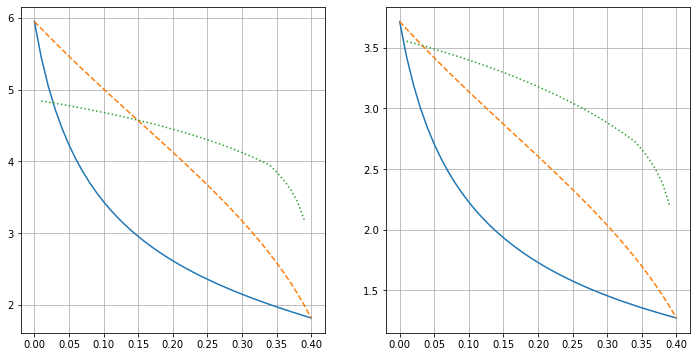

In [21]:
## plot soft/stiff models for qtz

qtz_k = 45
qtz_u = 36.6
dens = 2.65

pressure = 0.02
critical_porosity = 0.4
rc = 0.01

uncemented_sand_por = critical_porosity


## Porosity range for evaluation and plotting
porosity_range = np.arange(0, critical_porosity+0.01, 0.01)

## Coordination number from porosity
murphy_C=upper_murphy(porosity_range)

vp_soft, vs_soft = [],[]
vp_stiff, vs_stiff = [],[]

C_hm = round(upper_murphy(critical_porosity),2)
# Khm, Uhm = hertz_mindlin_angular(qtz_k, qtz_u, critical_porosity, C_hm,
#                                  pressure, Rc_ratio = rc, cohesionless_percent=0.5)

Khm, Uhm = hertz_mindlin(qtz_k, qtz_u, critical_porosity, C_hm, pressure, f=1)

for por, C in zip(porosity_range, murphy_C):
    k_soft, mu_soft = uncemented_model(por, critical_porosity, Khm, Uhm, qtz_k, qtz_u)
    k_stiff, mu_stiff = stiff_model(por, critical_porosity, Khm, Uhm, qtz_k, qtz_u)

    vp_soft.append(p_vel_mod(k_soft, mu_soft, dens*(1-por)))
    vs_soft.append(s_vel_mod(mu_soft, dens*(1-por)))
    vp_stiff.append(p_vel_mod(k_stiff, mu_stiff, dens*(1-por)))
    vs_stiff.append(s_vel_mod(mu_stiff, dens*(1-por)))
    
    
    
ice_k = 3.53
ice_u = 8.57
ice_dens = 0.94
crit_por = critical_porosity
trans_por = round((crit_por-(0.15*crit_por)),2)
vp_cont, vs_cont = [],[]

k_contact, u_contact, por_contact = self_consistent_contact_cement_SYM(ice_k, ice_u, qtz_k, 
                                        qtz_u, trans_por, crit_por, C, scheme='contact')
cont_dens = []
for por in por_contact:
    f_q = 1-crit_por
    f_c = crit_por - por
    cont_dens.append(sum([f_q*dens, f_c*ice_dens]))
    
for k, u, d in zip(k_contact, u_contact,cont_dens):
    vp_cont.append(p_vel_mod(k,u,d))
    vs_cont.append(s_vel_mod(u,d))


    
    
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax[0].plot(porosity_range, vp_soft)
ax[1].plot(porosity_range, vs_soft)
ax[0].plot(porosity_range, vp_stiff,'--')
ax[1].plot(porosity_range, vs_stiff,'--')
ax[0].plot(por_contact, vp_cont, ":")
ax[1].plot(por_contact, vs_cont, ":")
ax[0].grid('both')
ax[1].grid('both')
plt.show()

Running self-consistent iteration 30/30

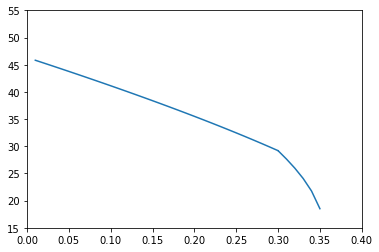

In [12]:
qtz_k = 45
qtz_u = 36.6
ice_k = 3.53
ice_u = 8.57
C=8
crit_por = 0.36
trans_por = 0.3

def M_mod(k,u):
    M = k + (4/3)*u
    return M




k_contact, u_contact, por_contact = self_consistent_contact_cement_SYM(ice_k, ice_u, qtz_k, 
                                        qtz_u, trans_por, crit_por, C, scheme='contact')


# M_fill = M_mod(k_fill,u_fill)
# print(M_fill)

M_mods = []
for k,u in zip(k_contact,u_contact):
    M_mods.append(M_mod(k,u))
    
plt.figure()
plt.plot(por_contact, M_mods)
plt.ylim(15,55)
plt.xlim(0,0.4)
plt.show()


Running self-consistent iteration 47/47

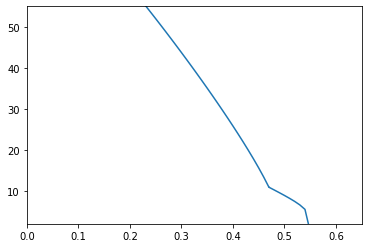

In [13]:
qtz_k = 45
qtz_u = 36.6
ice_k = 3.53
ice_u = 8.57
C=10
crit_por = 0.55
trans_por = round((crit_por-(0.15*crit_por)),2)



def M_mod(k,u):
    M = k + (4/3)*u
    return M




k_contact, u_contact, por_contact = self_consistent_contact_cement_SYM(ice_k, ice_u, qtz_k, 
                                        qtz_u, trans_por, crit_por, C, scheme='contact')


# M_fill = M_mod(k_fill,u_fill)
# print(M_fill)

M_mods = []
for k,u in zip(k_contact,u_contact):
    M_mods.append(M_mod(k,u))
    
plt.figure()
plt.plot(por_contact, M_mods)
plt.ylim(2,55)
plt.xlim(0,crit_por+0.1)
plt.show()


In [42]:
from sympy import symbols, Eq, solve

def z_var(k, u):
    z = (u*(9*k + 8*u)) / (6*(k + 2*u))
    return z

def b_var(k,u):
    b = u * ((3*k + u)/(3*k + 4*u))
    return b

def q_var(ki, ui, km, um, shape):

    if shape.lower()=='spheres':
        q = (um + z_var(km, um)) / (ui + z_var(km, um))

    if shape.lower()=='disks':
        q = (um + z_var(ki, ui)) / (ui + z_var(ki, ui))

    if shape.lower()=='penny cracks':
        q = (1/5) * (1 + (8*um / (4*ui + np.pi*crack_aspect_ratio*(um + 2*b_var(km, um)))) + \
                     2*((ki + 2/3*(ui + um))/(ki + 4/3*ui + np.pi*crack_aspect_ratio*b_var(km, um))))

    return q

def p_var(ki, ui, km, um, shape):

    if shape.lower()=='spheres':
        p = (km + (4/3)*um) / (ki + (4/3)*um)

    if shape.lower()=='disks':
        p = (km + (4/3)*ui) / (ki + (4/3)*ui)

    if shape.lower()=='penny cracks':
        p = (km + (4/3)*ui) / (ki + (4/3)*ui + np.pi*crack_aspect_ratio*b_var(km, um))

    return p

keff_tmp, ueff_tmp = symbols('keff_tmp ueff_tmp', positive=True)
por = 0.3
pore = 0.25
inclusion_shape = 'spheres'
ks, us = 17.41888946550743, 25.278138001915693
k_cement, mu_cement = k_ice, u_ice

eqk = Eq(((1-por)*(ks-keff_tmp)*p_var(ks, us, keff_tmp, ueff_tmp, inclusion_shape) + 
         (por - pore)*(k_cement - keff_tmp)*p_var(k_cement, mu_cement, keff_tmp, ueff_tmp, inclusion_shape) - 
         pore *keff_tmp*  p_var(0, 0, keff_tmp, ueff_tmp, inclusion_shape)),0)
    
equ = Eq(((1-por)*(us-ueff_tmp)*q_var(ks, us, keff_tmp, ueff_tmp, inclusion_shape) + 
         (por-pore)*(mu_cement-ueff_tmp)*q_var(k_cement, mu_cement, keff_tmp, ueff_tmp, inclusion_shape) - 
         pore *ueff_tmp*  q_var(0, 0, keff_tmp, ueff_tmp, inclusion_shape)),0)

berry = solve((eqk,equ), (keff_tmp, ueff_tmp))

In [44]:
print(berry)
print(type(berry))
print(berry[0][0])

[(9.68769100547730, 10.4678921000377)]
<class 'list'>
9.68769100547730


In [30]:
def M_mod(k,u):
    M = k + (4/3)*u
    return M

M_mod(9.68769100547730, 10.4678921000377)

23.64488047219423

In [41]:
x, y = symbols('x y')

def div(x, e):
    out = x/e
    return out

eq1 = Eq((x + y - 2 + div(x,3)),0)
eq2 = Eq((x - y + 12),0)

ans = solve((eq1,eq2), (x, y))

print((ans[x]))

-30/7


In [ ]:
def self_consistent_contact_cement_SYM_INT(k_cement, mu_cement, k_grain, mu_grain, 
                  por, crit_por, C, scheme, inclusion_shape='spheres',
                  crack_aspect_ratio=10e-2):
    """
    Combine self-consistent effective medium modeling with Contact Cement
    model to calculate effective moduli over full porosity range.
    Reference: Dvorkin et al. 1999
    
    Currently written for matrix, cement, and void phases. Only handles one 
    inclusion shape for both cement inclusion and voids
    
    !! UPDATE THIS TO TAKE ASPECT RATIO FOR VOIDS SEPERATE FROM CEMENT
    
    Inputs
        k_cement: bulk modulus of cement in GPa
        mu_cement: shear modulus of cement in GPa
        k_grain: grain bulk modulus in GPa
        mu_grain: grain shear bulk modulus in GPa
        por: porosity transition from cementing to pore-filling
        crit_por: critical porosity of uncemented matrix
        C: coordination number
        scheme: cementation scheme ('contact' or 'uniform')
        inclusion_shape: shape of included cement and voids
        crack_aspect_ratio: shape parameter for cement and voids
        
    Returns
        Array of effective bulk moduli in GPa for cemented sand model
        Array of effective shear moduli in GPa for cemented sand model 
        Porosity values corresponding to moduli
    """
    
    allowable_inclusions = ['spheres', 'disks', 'penny cracks']
    assert inclusion_shape.lower() in allowable_inclusions, "Inclusion shape not supported"


    ## Helper functions for P and Q coefficients
    ## RP handbook, page 187
    def z_var(k, u):
        z = (u*(9*k + 8*u)) / (6*(k + 2*u))
        return z
    
    def b_var(k,u):
        b = u * ((3*k + u)/(3*k + 4*u))
        return b

    def q_var(ki, ui, km, um, shape):
        
        if shape.lower()=='spheres':
            q = (um + z_var(km, um)) / (ui + z_var(km, um))
            
        if shape.lower()=='disks':
            q = (um + z_var(ki, ui)) / (ui + z_var(ki, ui))
            
        if shape.lower()=='penny cracks':
            q = (1/5) * (1 + (8*um / (4*ui + np.pi*crack_aspect_ratio*(um + 2*b_var(km, um)))) + \
                         2*((ki + 2/3*(ui + um))/(ki + 4/3*ui + np.pi*crack_aspect_ratio*b_var(km, um))))
            
        return q

    def p_var(ki, ui, km, um, shape):
        
        if shape.lower()=='spheres':
            p = (km + (4/3)*um) / (ki + (4/3)*um)
            
        if shape.lower()=='disks':
            p = (km + (4/3)*ui) / (ki + (4/3)*ui)
            
        if shape.lower()=='penny cracks':
            p = (km + (4/3)*ui) / (ki + (4/3)*ui + np.pi*crack_aspect_ratio*b_var(km, um))
            
        return p
    
    
    ## Get values from contact cement model
    k_contact, u_contact = [],[]
    cemented_por_range = np.arange(por,crit_por,0.01)
    for por_val in cemented_por_range:
        k_cem, u_cem = cemented_model(k_cement, mu_cement, k_grain, mu_grain, 
                  por_val, crit_por, C, scheme)
        k_contact.append(k_cem)
        u_contact.append(u_cem)
    
    
    ## Use self-consistent model to to calculate moduli between
    ## zero porosity and cemented fitting porosity
    k_cem, u_cem = cemented_model(k_cement, mu_cement, k_grain, mu_grain, 
                  por, crit_por, C, scheme)
    zs = z_var(k_cem, u_cem)
    ks = (((1/(k_cem + (4/3)*u_cem)) - (por / ((4/3)*u_cem)))**-1) * (1 - por) - (4/3)*u_cem
    us = (((1 / (u_cem + zs)) - (por / zs))**-1) * (1 - por) - zs

    k_fill, u_fill = hs_bound(bound='lower', volume_fracts=[crit_por, 1-crit_por], 
                              bulk_mods = [k_cement, k_grain], shear_mods = [mu_cement, mu_grain], porosity=0)

    
    ##!! THIS COULD BE REPLACED WITH SYMPY
    error_tolerance = 0.005

    while True:
        target_k = (por * (k_cement - k_fill) * p_var(k_cement, mu_cement, k_fill, u_fill, inclusion_shape)) / \
                    ((1 - por) * p_var(ks, us, k_fill, u_fill, inclusion_shape)) + ks

        if target_k > voight_average([crit_por, 1-crit_por], [k_grain, k_cement]):
            target_k = voight_average([crit_por, 1-crit_por], [k_grain, k_cement])
        if target_k < reuss_average([crit_por, 1-crit_por], [k_grain, k_cement]):
            target_k = reuss_average([crit_por, 1-crit_por], [k_grain, k_cement])

        target_u = (por * (mu_cement - u_fill) * q_var(k_cement, mu_cement, k_fill, u_fill, inclusion_shape)) / \
                ((1 - por) * q_var(ks, us, k_fill, u_fill, inclusion_shape)) + us

        if target_u > voight_average([crit_por, 1-crit_por], [mu_grain, mu_cement]):
            target_u = voight_average([crit_por, 1-crit_por], [mu_grain, mu_cement])
        if target_u < reuss_average([crit_por, 1-crit_por], [mu_grain, mu_cement]):
            target_u = reuss_average([crit_por, 1-crit_por], [mu_grain, mu_cement])

        if (np.abs(target_k - k_fill) > error_tolerance) and (np.abs(target_u - u_fill) > error_tolerance):
            k_fill = target_k
            u_fill = target_u
            continue
        else:
            k_fill = target_k
            u_fill = target_u
            break



    keff_dvorkin, ueff_dvorkin = [],[]

    empty_porosity = np.arange(por, 0.0, -0.01)
    
    keff_tmp, ueff_tmp = symbols('keff_tmp ueff_tmp', positive=True)
    
    k_start, u_start = k_cem, u_cem

    iter_counter = 1
    for pore in empty_porosity:
        sys.stdout.write("\rRunning self-consistent iteration {}/{}".format(iter_counter,len(empty_porosity)))
        sys.stdout.flush()
        
        pore = round(pore, 2)
        
        eqk = Eq(((1-por)*(ks-keff_tmp)*p_var(ks, us, keff_tmp, ueff_tmp, inclusion_shape) + 
         (por - pore)*(k_cement - keff_tmp)*p_var(k_cement, mu_cement, keff_tmp, ueff_tmp, inclusion_shape) - 
         pore *keff_tmp*  p_var(0, 0, keff_tmp, ueff_tmp, inclusion_shape)),0)
    
        equ = Eq(((1-por)*(us-ueff_tmp)*q_var(ks, us, keff_tmp, ueff_tmp, inclusion_shape) + 
                 (por-pore)*(mu_cement-ueff_tmp)*q_var(k_cement, mu_cement, keff_tmp, ueff_tmp, inclusion_shape) - 
                 pore *ueff_tmp*  q_var(0, 0, keff_tmp, ueff_tmp, inclusion_shape)),0)
        
        iter_solve = solve((eqk, equ), (keff_tmp, ueff_tmp))
        if len(iter_solve)==0:
            iter_solve = nsolve((eqk, equ), (keff_tmp, ueff_tmp), (k_start, u_start))
#         sys.stdout.write("iter_solve length: {}".format(len(iter_solve)))
#         sys.stdout.write("iter_solve result: {}".format(iter_solve))
#         iter_solve = np.array(iter_solve)
#         sys.stdout.write("iter_solve result2: {}".format(iter_solve))
        
        try:
            target_keff = iter_solve[0][0]
            target_ueff = iter_solve[0][1]
#             target_keff = iter_solve[0]
#             target_ueff = iter_solve[1]
            
        except IndexError:
#             sys.stdout.write("iter_solve result: {}".format(iter_solve))
            target_keff = iter_solve[0]
            target_ueff = iter_solve[1]
        
        keff_dvorkin.append(target_keff)
        ueff_dvorkin.append(target_ueff)
        k_start, u_start = target_keff, target_ueff
        
        iter_counter+=1
                
    ## Gather up moduli and porosity values
    porosity = np.hstack((np.flip(empty_porosity), cemented_por_range))
    
    keff_dvorkin.reverse()
    k = np.hstack((np.array(keff_dvorkin), np.array(k_contact)))
    
    ueff_dvorkin.reverse()
    u = np.hstack((np.array(ueff_dvorkin), np.array(u_contact)))
    
    return k, u, porosity





In [3]:
from sympy import symbols, Eq, solve, nsolve

In [4]:
## DECONSTRUCT SYM INT

inclusion_shape='spheres'
crack_aspect_ratio=10e-2
scheme='contact'

## Mineral Parameters and Mixing
k_olivine, u_olivine, f_olivine, d_olivine = 130, 80, 0.05, 3.32  #from RP handbook
k_diopside, u_diopside, f_diopside, d_diopside = 111.2, 63.7, 0.1, 3.31   #from RP handbook
k_plag, u_plag, f_plag, d_plag = 75.6, 25.6, 0.15, 2.63     #from RP handbook
k_anorthite, u_anorthite, f_anorthite, d_anorthite = 66., 33.7, 0.7, 2.7  # from Brown 2016

min_volume_fractions = [f_olivine, f_diopside, f_plag, f_anorthite]
min_bulk_mods = [k_olivine, k_diopside, k_plag, k_anorthite]
min_shear_mods = [u_olivine, u_diopside, u_plag, u_anorthite]
min_densities = [d_olivine, d_diopside, d_plag, d_anorthite]

effective_mineral_k = hill_average(min_volume_fractions, min_bulk_mods)
effective_mineral_u = hill_average(min_volume_fractions, min_shear_mods)
eff_min_density = sum([f*d for f, d in zip(min_volume_fractions, min_densities)])


## Ice Parameters
ice_temp = -100
ice_vp = (3837.9 - 2.812*ice_temp) / 1000  # from Vogt 2008
ice_vs = (1826 - 1.425*ice_temp) / 1000
ice_dens = (917 - 0.1403*ice_temp) / 1000 # from Pounder 1965

k_ice = bulk_mod(ice_vp, ice_vs, ice_dens)
u_ice = shear_mod(ice_vs, ice_dens)


k_cement, mu_cement = k_ice, u_ice
k_grain, mu_grain = effective_mineral_k, effective_mineral_u




## Misc
pressure = 0.0000035
critical_porosity = 0.6
crit_por = critical_porosity
rc = 0.01

rock_porosity = critical_porosity
cemented_porosity = round(rock_porosity-(rock_porosity*.15), 2)
C=5
por = cemented_porosity


def z_var(k, u):
    z = (u*(9*k + 8*u)) / (6*(k + 2*u))
    return z

def b_var(k,u):
    b = u * ((3*k + u)/(3*k + 4*u))
    return b

def q_var(ki, ui, km, um, shape):

    if shape.lower()=='spheres':
        q = (um + z_var(km, um)) / (ui + z_var(km, um))

    if shape.lower()=='disks':
        q = (um + z_var(ki, ui)) / (ui + z_var(ki, ui))

    if shape.lower()=='penny cracks':
        q = (1/5) * (1 + (8*um / (4*ui + np.pi*crack_aspect_ratio*(um + 2*b_var(km, um)))) + \
                     2*((ki + 2/3*(ui + um))/(ki + 4/3*ui + np.pi*crack_aspect_ratio*b_var(km, um))))

    return q

def p_var(ki, ui, km, um, shape):

    if shape.lower()=='spheres':
        p = (km + (4/3)*um) / (ki + (4/3)*um)

    if shape.lower()=='disks':
        p = (km + (4/3)*ui) / (ki + (4/3)*ui)

    if shape.lower()=='penny cracks':
        p = (km + (4/3)*ui) / (ki + (4/3)*ui + np.pi*crack_aspect_ratio*b_var(km, um))

    return p


## Get values from contact cement model
k_contact, u_contact = [],[]
cemented_por_range = np.arange(por,crit_por,0.01)
for por_val in cemented_por_range:
    k_cem, u_cem = cemented_model(k_cement, mu_cement, k_grain, mu_grain, 
              por_val, crit_por, C, scheme)
    k_contact.append(k_cem)
    u_contact.append(u_cem)


## Use self-consistent model to to calculate moduli between
## zero porosity and cemented fitting porosity
k_cem, u_cem = cemented_model(k_cement, mu_cement, k_grain, mu_grain, 
              por, crit_por, C, scheme)
zs = z_var(k_cem, u_cem)
ks = (((1/(k_cem + (4/3)*u_cem)) - (por / ((4/3)*u_cem)))**-1) * (1 - por) - (4/3)*u_cem
us = (((1 / (u_cem + zs)) - (por / zs))**-1) * (1 - por) - zs

k_fill, u_fill = hs_bound(bound='lower', volume_fracts=[crit_por, 1-crit_por], 
                          bulk_mods = [k_cement, k_grain], shear_mods = [mu_cement, mu_grain], porosity=0)


##!! THIS COULD BE REPLACED WITH SYMPY
error_tolerance = 0.005

while True:
    target_k = (por * (k_cement - k_fill) * p_var(k_cement, mu_cement, k_fill, u_fill, inclusion_shape)) / \
                ((1 - por) * p_var(ks, us, k_fill, u_fill, inclusion_shape)) + ks

    if target_k > voight_average([crit_por, 1-crit_por], [k_grain, k_cement]):
        target_k = voight_average([crit_por, 1-crit_por], [k_grain, k_cement])
    if target_k < reuss_average([crit_por, 1-crit_por], [k_grain, k_cement]):
        target_k = reuss_average([crit_por, 1-crit_por], [k_grain, k_cement])

    target_u = (por * (mu_cement - u_fill) * q_var(k_cement, mu_cement, k_fill, u_fill, inclusion_shape)) / \
            ((1 - por) * q_var(ks, us, k_fill, u_fill, inclusion_shape)) + us

    if target_u > voight_average([crit_por, 1-crit_por], [mu_grain, mu_cement]):
        target_u = voight_average([crit_por, 1-crit_por], [mu_grain, mu_cement])
    if target_u < reuss_average([crit_por, 1-crit_por], [mu_grain, mu_cement]):
        target_u = reuss_average([crit_por, 1-crit_por], [mu_grain, mu_cement])

    if (np.abs(target_k - k_fill) > error_tolerance) and (np.abs(target_u - u_fill) > error_tolerance):
        k_fill = target_k
        u_fill = target_u
        continue
    else:
        k_fill = target_k
        u_fill = target_u
        break
        
print(k_fill, u_fill)

22.442363347215977 7.847651990444395


In [8]:
print(empty_porosity)

[0.51 0.5  0.49 0.48 0.47 0.46 0.45 0.44 0.43 0.42 0.41 0.4  0.39 0.38
 0.37 0.36 0.35 0.34 0.33 0.32 0.31 0.3  0.29 0.28 0.27 0.26 0.25 0.24
 0.23 0.22 0.21 0.2  0.19 0.18 0.17 0.16 0.15 0.14 0.13 0.12 0.11 0.1
 0.09 0.08 0.07 0.06 0.05 0.04 0.03 0.02 0.01]


In [5]:
keff_dvorkin, ueff_dvorkin = [],[]

empty_porosity = np.arange(por, 0.0, -0.01)

keff_tmp, ueff_tmp = symbols('keff_tmp ueff_tmp', positive=True)

k_start, u_start = k_cem, u_cem

print("Cemented K, U: ",k_cem, u_cem)

# iter_counter = 1
# for pore in empty_porosity:
#     print("\rRunning self-consistent iteration {}/{}".format(iter_counter,len(empty_porosity)))

pore = 0.49

pore = round(pore, 2)

eqk = Eq(((1-por)*(ks-keff_tmp)*p_var(ks, us, keff_tmp, ueff_tmp, inclusion_shape) + 
 (por - pore)*(k_cement - keff_tmp)*p_var(k_cement, mu_cement, keff_tmp, ueff_tmp, inclusion_shape) - 
 pore *keff_tmp*  p_var(0, 0, keff_tmp, ueff_tmp, inclusion_shape)),0)

equ = Eq(((1-por)*(us-ueff_tmp)*q_var(ks, us, keff_tmp, ueff_tmp, inclusion_shape) + 
         (por-pore)*(mu_cement-ueff_tmp)*q_var(k_cement, mu_cement, keff_tmp, ueff_tmp, inclusion_shape) - 
         pore *ueff_tmp*  q_var(0, 0, keff_tmp, ueff_tmp, inclusion_shape)),0)

# iter_solve = solve((eqk, equ), (keff_tmp, ueff_tmp))
# if len(iter_solve)==0:
iter_solve = nsolve((eqk, equ), (keff_tmp, ueff_tmp), (k_start, u_start))
    
print("porosity {} result: {}".format(pore, iter_solve))

try:
    target_keff = iter_solve[0][0]
    target_ueff = iter_solve[0][1]
#             target_keff = iter_solve[0]
#             target_ueff = iter_solve[1]

except:
    target_keff = iter_solve[0]
    target_ueff = iter_solve[1]

keff_dvorkin.append(target_keff)
ueff_dvorkin.append(target_ueff)
k_start, u_start = target_keff, target_ueff

print(target_keff, target_ueff)

# iter_counter += 1

Cemented K, U:  4.567684670368598 5.000874584367116
porosity 0.49 result: Matrix([[-3.66705900745640e-16], [-3.41693963766929e-16]])
-3.66705900745640e-16 -3.41693963766929e-16
